In [42]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import re
#from wordcloud import WordCloud

from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [54]:
total_data= pd.read_csv('/content/drive/Shareddrives/흐사드/0702_0706_파일정리/임팩타민/임팩타민_2019_2022.csv',encoding='utf-8')
total_data

,Unnamed: 0,날짜,제목,연도
0,51,20190123,[열려라 공부+] 수험생 피로 회복에 좋은 비타민 복합제,2019
1,52,20190312,"[Hello, 헬스] 비타민제, 무엇을 드시나요?",2019
2,53,20190307,Pharma firms go all-out in increasing R&D capa...,2019
3,54,20190306,"대웅제약, 매출 1조 클럽 가입",2019
4,55,20190306,"대웅제약, 매출 1조 클럽 가입..영업익은 36% 하락",2019
...,...,...,...,...
16032,8788,20220302,약국 어디가 싼가요?,2022
16033,8789,20220302,최근에 임팩타민 사신분들 색깔 좀봐주세요,2022
16034,8790,20220302,루테인?,2022
16035,8791,20220301,비타민B 좀 봐주세요,2022


In [55]:
total_data=total_data[['날짜','제목']]
total_data=total_data.drop_duplicates()
total_data

,날짜,제목
0,20190123,[열려라 공부+] 수험생 피로 회복에 좋은 비타민 복합제
1,20190312,"[Hello, 헬스] 비타민제, 무엇을 드시나요?"
2,20190307,Pharma firms go all-out in increasing R&D capa...
3,20190306,"대웅제약, 매출 1조 클럽 가입"
4,20190306,"대웅제약, 매출 1조 클럽 가입..영업익은 36% 하락"
...,...,...
16032,20220302,약국 어디가 싼가요?
16033,20220302,최근에 임팩타민 사신분들 색깔 좀봐주세요
16034,20220302,루테인?
16035,20220301,비타민B 좀 봐주세요


In [56]:
#데이터 프레임의 'text' 열의 값들을 str 형식으로 바꾸기
total_data.제목 = total_data.제목.astype(str)


#데이터 프레임의 'text' 열의 값 중 keyword1이나 keyword 2가 포함된 행은 삭제
#clean_Data = total_data[~total_data['제목'].str.contains('keyword1|keyword2')]


#text와 timestamp 열을 기준으로 중복된 데이터를 삭제, inplace : 데이터 프레임을 변경할지 선택(원본을 대체)
total_data.drop_duplicates(subset=['제목','날짜'], inplace=True)

#빈 문자열 NAN 값으로 바꾸기
total_data = total_data.replace({'': np.nan})
total_data = total_data.replace(r'^\s*$', None, regex=True)

#NAN 이 있는 행은 삭제
total_data.dropna(how='any', inplace=True)

#인덱스 차곡차곡
total_data = total_data.reset_index (drop = True)

#데이터 프레임에 null 값이 있는지 확인
print(total_data.isnull().values.any()) 

False


In [57]:
#텍스트 데이터를 리스트로 변환
Data_li=total_data.제목.values.tolist()
Data_li

['[열려라 공부+] 수험생 피로 회복에 좋은 비타민 복합제',
 '[Hello, 헬스] 비타민제, 무엇을 드시나요?',
 'Pharma firms go all-out in increasing R&D capaciti...',
 '대웅제약, 매출 1조 클럽 가입',
 '대웅제약, 매출 1조 클럽 가입..영업익은 36% 하락',
 '`1조클럽이지만…` 대웅제약, 작년 영업이익 246억원…전년比 36.9%',
 "지난해 일반의약품 판매 1위 '아로나민'",
 '아로나민, 지난해 일반의약품 매출 1위 차지…2017년 매출 정점찍고 하강그래프 그려',
 "[머니+ 트렌드 맞춰 '취업뽀개기'] 삼바 '경영지원직' 공략... 셀트리온헬스케어 '영어...",
 '지난해 가장 많이 팔린 일반의약품은?',
 '지난해 일반약 매출 1위는 `아로나민`',
 "'의사 처방 없이 구매' 지난해 일반약 매출 1위는?",
 "지난해 가장 많이 팔린 일반약 '아로나민'",
 '커피 섭취량, ‘비타민 B’ 감소 및 대사성 질환 발생 위험 증가',
 '대웅제약, 1분기 실적 전년 比 매출 10.3%, 영업익 27.2% 증가',
 '대웅제약, 1분기 영업익 102억원…전년비 27.2%',
 '대웅제약, 1분기 영업이익 27.2%…‘나보타’ 수출 실적 가시화',
 '대웅제약, 1분기 영업이익 102억원…전년 동기 대비 27.2%',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 미국 매출로 실적 향상"',
 '대웅제약 \'나보타\' 美 수출, 전년동기대비 1107% 성장…"양호한 이익개선 기대"',
 '대웅제약, 1분기 매출 10%, 영업이익 27% 성장',
 '대웅제약, 1분기 영업익 102억원… 전년 대비 27% ',
 '대웅제약, 1분기 영업이익 27.2% 늘었다··“나보타의 힘”',
 '대웅제약, 1Q 영업익 전년比 27% 증가…"나보타 美매출 반영"',
 '대웅제약, 1Q 영업익 102억…"나보타 美 매출로 수익성 향상"',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 美 매

In [58]:
company=['비맥스메타','임펙타민','임팩타민']
out=list()

for i in Data_li:
  if company[0] in i or company[1] in i or company[2] in i  :
    pass
  else:
    out.append(i)


In [59]:
out

['[열려라 공부+] 수험생 피로 회복에 좋은 비타민 복합제',
 '[Hello, 헬스] 비타민제, 무엇을 드시나요?',
 'Pharma firms go all-out in increasing R&D capaciti...',
 '대웅제약, 매출 1조 클럽 가입',
 '대웅제약, 매출 1조 클럽 가입..영업익은 36% 하락',
 '`1조클럽이지만…` 대웅제약, 작년 영업이익 246억원…전년比 36.9%',
 "지난해 일반의약품 판매 1위 '아로나민'",
 '아로나민, 지난해 일반의약품 매출 1위 차지…2017년 매출 정점찍고 하강그래프 그려',
 "[머니+ 트렌드 맞춰 '취업뽀개기'] 삼바 '경영지원직' 공략... 셀트리온헬스케어 '영어...",
 '지난해 가장 많이 팔린 일반의약품은?',
 '지난해 일반약 매출 1위는 `아로나민`',
 "'의사 처방 없이 구매' 지난해 일반약 매출 1위는?",
 "지난해 가장 많이 팔린 일반약 '아로나민'",
 '커피 섭취량, ‘비타민 B’ 감소 및 대사성 질환 발생 위험 증가',
 '대웅제약, 1분기 실적 전년 比 매출 10.3%, 영업익 27.2% 증가',
 '대웅제약, 1분기 영업익 102억원…전년비 27.2%',
 '대웅제약, 1분기 영업이익 27.2%…‘나보타’ 수출 실적 가시화',
 '대웅제약, 1분기 영업이익 102억원…전년 동기 대비 27.2%',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 미국 매출로 실적 향상"',
 '대웅제약 \'나보타\' 美 수출, 전년동기대비 1107% 성장…"양호한 이익개선 기대"',
 '대웅제약, 1분기 매출 10%, 영업이익 27% 성장',
 '대웅제약, 1분기 영업익 102억원… 전년 대비 27% ',
 '대웅제약, 1분기 영업이익 27.2% 늘었다··“나보타의 힘”',
 '대웅제약, 1Q 영업익 전년比 27% 증가…"나보타 美매출 반영"',
 '대웅제약, 1Q 영업익 102억…"나보타 美 매출로 수익성 향상"',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 美 매

In [60]:
Data_list=out
Data_list

['[열려라 공부+] 수험생 피로 회복에 좋은 비타민 복합제',
 '[Hello, 헬스] 비타민제, 무엇을 드시나요?',
 'Pharma firms go all-out in increasing R&D capaciti...',
 '대웅제약, 매출 1조 클럽 가입',
 '대웅제약, 매출 1조 클럽 가입..영업익은 36% 하락',
 '`1조클럽이지만…` 대웅제약, 작년 영업이익 246억원…전년比 36.9%',
 "지난해 일반의약품 판매 1위 '아로나민'",
 '아로나민, 지난해 일반의약품 매출 1위 차지…2017년 매출 정점찍고 하강그래프 그려',
 "[머니+ 트렌드 맞춰 '취업뽀개기'] 삼바 '경영지원직' 공략... 셀트리온헬스케어 '영어...",
 '지난해 가장 많이 팔린 일반의약품은?',
 '지난해 일반약 매출 1위는 `아로나민`',
 "'의사 처방 없이 구매' 지난해 일반약 매출 1위는?",
 "지난해 가장 많이 팔린 일반약 '아로나민'",
 '커피 섭취량, ‘비타민 B’ 감소 및 대사성 질환 발생 위험 증가',
 '대웅제약, 1분기 실적 전년 比 매출 10.3%, 영업익 27.2% 증가',
 '대웅제약, 1분기 영업익 102억원…전년비 27.2%',
 '대웅제약, 1분기 영업이익 27.2%…‘나보타’ 수출 실적 가시화',
 '대웅제약, 1분기 영업이익 102억원…전년 동기 대비 27.2%',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 미국 매출로 실적 향상"',
 '대웅제약 \'나보타\' 美 수출, 전년동기대비 1107% 성장…"양호한 이익개선 기대"',
 '대웅제약, 1분기 매출 10%, 영업이익 27% 성장',
 '대웅제약, 1분기 영업익 102억원… 전년 대비 27% ',
 '대웅제약, 1분기 영업이익 27.2% 늘었다··“나보타의 힘”',
 '대웅제약, 1Q 영업익 전년比 27% 증가…"나보타 美매출 반영"',
 '대웅제약, 1Q 영업익 102억…"나보타 美 매출로 수익성 향상"',
 '대웅제약, 1분기 영업이익 27% 증가…"나보타 美 매

In [61]:
from konlpy.tag import Okt
okt = Okt()

In [62]:
okt.nouns(Data_list[0])

['공부', '수험생', '피로', '회복', '비타민', '복합', '제']

In [63]:

#리스트를 요소별로(트윗 하나) 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
#스탑워드
stopword=['로나', '민', '골드','아로','좀','양제','비타민','영',"제","거","요","뭐","알","살","수","저","이","때","곳","더","나","것","안","내","걸","게","날","개","말","또","전","함","비","분","정","및","진짜","를","자주","주차"]
for i in range(len(Data_list)):
  k=[]
  try:
      a=okt.nouns(Data_list[i])
      for j in a:
        if j not in stopword:
          k.append(j)
      data_word.append(k)
  except Exception as e:
        continue


#트윗에서 형태소 추출해서 만든 리스트
data_word

[['공부', '수험생', '피로', '회복', '복합'],
 ['헬스', '무엇'],
 [],
 ['대웅제약', '매출', '클럽', '가입'],
 ['대웅제약', '매출', '클럽', '가입', '영업', '하락'],
 ['대웅제약', '작년', '영업', '이익', '년'],
 ['지난해', '일반의약품', '판매', '위'],
 ['지난해', '일반의약품', '매출', '위', '차지', '매출', '정점', '하강', '그래프'],
 ['트렌드', '취업', '뽀', '삼바', '직', '공략', '셀트리온', '헬', '스케', '영어'],
 ['지난해', '가장', '일반의약품'],
 ['지난해', '일반', '약', '매출', '위'],
 ['의사', '처방', '구매', '지난해', '일반', '약', '매출', '위'],
 ['지난해', '가장', '일반', '약'],
 ['커피', '섭취', '량', '감소', '대사성', '질환', '발생', '위험', '증가'],
 ['대웅제약', '실적', '년', '매출', '영업', '익', '증가'],
 ['대웅제약', '영업', '익', '년비'],
 ['대웅제약', '영업', '이익', '나보타', '수출', '실적', '가시'],
 ['대웅제약', '영업', '이익', '년', '동기', '대비'],
 ['대웅제약', '영업', '이익', '증가', '나보타', '미국', '매출', '실적', '향상'],
 ['대웅제약', '나보타', '수출', '년', '대비', '성장', '양호', '이익', '개선', '기대'],
 ['대웅제약', '매출', '영업', '이익', '성장'],
 ['대웅제약', '영업', '익', '년', '대비'],
 ['대웅제약', '영업', '이익', '나보', '타의', '힘'],
 ['대웅제약', '영업', '익', '년', '증가', '나보타', '매출', '반영'],
 ['대웅제약', '영업', '익', '나보타', '매출', '수익', '향상'],
 ['대

In [64]:
from gensim import corpora

# 각 단어를 (단어id, 나온횟수) 로 바꾸는 작업
dictionary = corpora.Dictionary(data_word)
corpus = [dictionary.doc2bow(text) for text in data_word]

In [65]:
import gensim

In [66]:
import matplotlib.pyplot as plt
perplexity_values=[]
for i in range(2,15):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
  perplexity_values.append(ldamodel.log_perplexity(corpus))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

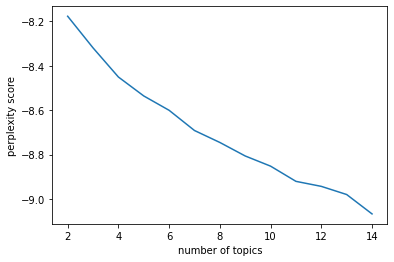

In [67]:
x=range(2,15)
plt.plot(x,perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [68]:
from gensim.models import CoherenceModel
coherance_values=[]
for i in range(2,15):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
  coherance_model_lda=CoherenceModel(model=ldamodel,texts=data_word,dictionary=dictionary,topn=10)
  coherance_lda=coherance_model_lda.get_coherence()
  coherance_values.append(coherance_lda)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

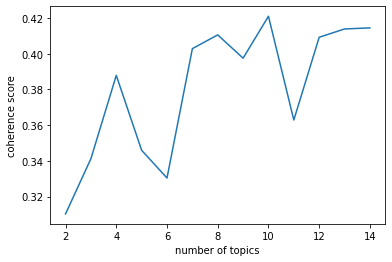

In [69]:
x=range(2,15)
plt.plot(x,coherance_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [70]:
# corpus[i] : i번째 뉴스에서 나온단어들을 가지고 (단어id, 나온횟수)들을 저장한 list
print(corpus[1]) 


# dictionary[j] : id값을 j를 가진 단어가 무엇인지 확인
print(dictionary[66])

[(5, 1), (6, 1)]
반영


In [71]:
import gensim

NUM_TOPICS = 4

# passes : 알고리즘 동작횟수, num_words : 각 토픽별 출력할 단어
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

(0, '0.018*"대웅제약" + 0.009*"영업" + 0.009*"보신" + 0.008*"면역"')
(1, '0.029*"남편" + 0.019*"건강" + 0.014*"선물" + 0.011*"질문"')
(2, '0.089*"추천" + 0.087*"약국" + 0.032*"피로" + 0.021*"회복"')
(3, '0.024*"종합" + 0.013*"함량" + 0.013*"맥스" + 0.011*"복용"')


In [72]:
# 각 토픽별 10개의 단어를 단어를 출력 (위 코드에서 num_words=10을 한것)
for i in range(NUM_TOPICS):
    print(ldamodel.print_topics()[i])

(0, '0.018*"대웅제약" + 0.009*"영업" + 0.009*"보신" + 0.008*"면역" + 0.008*"코로나" + 0.007*"오늘" + 0.007*"후기" + 0.007*"매출" + 0.007*"준비" + 0.007*"고등"')
(1, '0.029*"남편" + 0.019*"건강" + 0.014*"선물" + 0.011*"질문" + 0.011*"요즘" + 0.010*"약국" + 0.009*"구내염" + 0.009*"하루" + 0.008*"구매" + 0.007*"문의"')
(2, '0.089*"추천" + 0.087*"약국" + 0.032*"피로" + 0.021*"회복" + 0.017*"약" + 0.015*"수험생" + 0.015*"종합" + 0.013*"남대문" + 0.013*"종로" + 0.012*"가격"')
(3, '0.024*"종합" + 0.013*"함량" + 0.013*"맥스" + 0.011*"복용" + 0.010*"효과" + 0.009*"관리" + 0.008*"중" + 0.007*"체력" + 0.007*"공부" + 0.006*"오메가"')


In [73]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [75]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.04331973), (1, 0.04167068), (2, 0.7121582), (3, 0.20285137)]
1 번째 문서의 topic 비율은 [(0, 0.7364864), (1, 0.08340934), (2, 0.08339011), (3, 0.096714154)]
2 번째 문서의 topic 비율은 [(0, 0.25), (1, 0.25), (2, 0.25), (3, 0.25)]
3 번째 문서의 topic 비율은 [(0, 0.84998703), (1, 0.05000462), (2, 0.050004233), (3, 0.050004102)]
4 번째 문서의 topic 비율은 [(0, 0.8928193), (1, 0.03572787), (2, 0.035726435), (3, 0.03572645)]


In [76]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [77]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,2.0,0.7122,"[(0, 0.043322735), (1, 0.041670684), (2, 0.712..."
1,1,0.0,0.7366,"[(0, 0.7365742), (1, 0.08340934), (2, 0.083390..."
2,2,0.0,0.2500,"[(0, 0.25), (1, 0.25), (2, 0.25), (3, 0.25)]"
3,3,0.0,0.8500,"[(0, 0.84998703), (1, 0.05000462), (2, 0.05000..."
4,4,0.0,0.8928,"[(0, 0.8928193), (1, 0.035727873), (2, 0.03572..."
5,5,0.0,0.8750,"[(0, 0.8749961), (1, 0.04166816), (2, 0.041667..."
6,6,3.0,0.8449,"[(0, 0.05394997), (1, 0.050196003), (2, 0.0509..."
7,7,0.0,0.7167,"[(0, 0.7167028), (1, 0.025218222), (2, 0.02613..."
8,8,2.0,0.9301,"[(0, 0.024214271), (1, 0.022917604), (2, 0.930..."
9,9,3.0,0.8035,"[(0, 0.070367165), (1, 0.06303391), (2, 0.0630..."
